### This file is for experiments

In [1]:
import cv2
import os
import torch
import pickle as pkl
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.optim as optim

In [2]:
# lazy loading data
class LazyLoadDataset(Dataset):
    def __init__(self, path, train = True, transform = None):
        self.transform = transform
        self.train = train
        path = path + ('train/' if train else 'test/')

        self.pathX = path + 'X/'
        self.pathY = path + 'Y/'

        self.data = os.listdir(self.pathX)
    
    def __getitem__(self, index):
        f = self.data[index]

        # X
        # read rgb images
        img0 = cv2.imread(self.pathX + f + '/rgb/0.png')
        img1 = cv2.imread(self.pathX + f + '/rgb/1.png')
        img2 = cv2.imread(self.pathX + f + '/rgb/2.png')

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        # read depth
        depth = np.load(self.pathX + f + '/depth.npy') / 1000

        #read field id
        field_id = pkl.load(open(self.pathX + f + '/field_id.pkl', 'rb'))

        # Y
        if self.train:
            Y = np.load(self.pathY + f + '.npy')

            return (img0, img1, img2, depth, field_id), Y
        else:
            return (img0, img1, img2, depth, field_id)
        
    def __len__(self):
        return len(self.data)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), ])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels = 1)])

dataset = LazyLoadDataset('./lazydata/', transform = transform)

In [ ]:
# train_dataset = LazyLoadDataset('./lazydata/', transform = transform)
train_dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

# calculate mean and standard deviation of the train dataset
def get_mean_std(loader):
    (img0, img1, img2, depth, field_id), Y = next(iter(loader))
    # (img0, _, _, _, _), _ = next(iter(loader))
    img0_mean = img0.mean([0,2,3])
    img0_std = img0.std([0,2,3])
    img1_mean = img1.mean([0,2,3])
    img1_std = img1.std([0,2,3])
    img2_mean = img2.mean([0,2,3])
    img2_std = img2.std([0,2,3])
    mean, std = (img0_mean + img1_mean + img2_mean) / 3, (img0_std + img1_std + img2_std) / 3
    # mean, std = img0_mean, img0_std
    return mean, std


In [ ]:
mean, std = get_mean_std(train_dataloader)
print("mean and std: \n", mean, std)

In [4]:
# mean and std for rgbs
mean = torch.Tensor([0.4851, 0.4623, 0.4356])
std = torch.Tensor([0.2195, 0.2181, 0.2339])

# mean and std for grayscale images
# mean = torch.Tensor([0.4660])
# std = torch.Tensor([0.2163])

# mean and std for img0 only
# mean = torch.Tensor([0.4352, 0.4170, 0.3960])
# std = torch.Tensor([0.1997, 0.1991, 0.2120])

In [5]:
transform_with_normalization = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std),])
# transform_with_normalization = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels = 1), transforms.Normalize(mean, std),])
dataset = LazyLoadDataset('./lazydata/', transform = transform_with_normalization)

# split the train dataset to create a test dataset to test locally
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64 * 2, shuffle=True)

In [ ]:
# depth.shape

In [ ]:
# Y.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


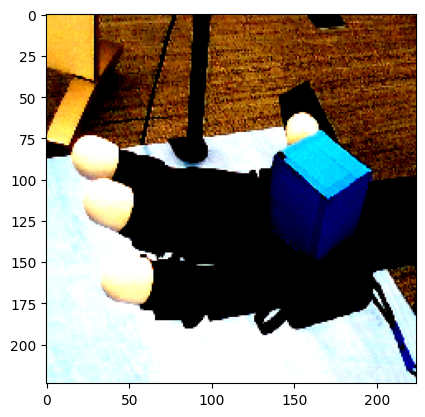

In [6]:
import matplotlib.pyplot as plt

for (img0, img1, img2, depth, field_id), Y in train_dataloader:
    # print(depth[1].squeeze().shape)
    # print(img0[0].shape)
    plt.imshow(img2[20].squeeze().permute(1, 2, 0))
    # plt.imshow(img0[0].squeeze(), cmap='gray')
    # plt.imshow(depth[0][2].squeeze())
    plt.show()
    break

plt.show()

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train with CNN

In [8]:
# AlexNet architecture
class CNN(nn.Module):
    def __init__(self, input_channels, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(conv_feature * 6 * 6, fc_feature)
        self.fc2 = nn.Linear(fc_feature, fc_feature)
        self.fc3 = nn.Linear(fc_feature, output_size)
        
    def forward(self, x):
        # print(x.shape)
        x = self.relu(self.conv1(x))
        # print(x.shape)
        x = self.maxpool(x)
        # print(x.shape)
        x = self.relu(self.conv2(x))
        # print(x.shape)
        x = self.maxpool(x)
        # print(x.shape)
        x = self.relu(self.conv3(x))
        # print(x.shape)
        x = self.relu(self.conv4(x))
        # print(x.shape)
        x = self.relu(self.conv5(x))
        # print(x.shape)
        x = self.maxpool(x)
        # print(x.shape)
        x = self.avgpool(x)
        x = self.flatten(x)
        # print(x.shape)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        # print(x.shape)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        # print(x.shape)
        x = self.fc3(x)
        # print(x.shape)
        # x = self.log_softmax(x)
        return x

In [9]:
def train(epoch, model, optimizer):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        permute_pixels (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.train()
    loss_per_epoch = 0
    for batch_idx, ((img0, img1, img2, depth, field_id), target) in enumerate(train_dataloader):
        # send three images to device
        data = torch.cat((img0, img1, img2, depth), dim=1).to(device)
        # only send img0 to device
        # data = img0.to(device)

        # send target to device
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)

        # l1 loss
        # loss = nn.L1Loss()(output.float(), target.float() * 1000.0)

        # mseloss
        loss = nn.MSELoss()(output.float(), target.float() * 1000.0)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_dataloader.dataset),
            100. * batch_idx / len(train_dataloader), loss.item()))
        loss_per_epoch += loss.item()
    return loss_per_epoch / train_size


In [10]:
# test the model
def test(model):
    model.eval()
    test_loss = 0

    for batch_idx, ((img0, img1, img2, depth, field_id), target) in enumerate(test_dataloader):
        # send three images to device
        data = torch.cat((img0, img1, img2, depth), dim=1).to(device)
        # only send img0 to device
        # data = img0.to(device)

        target = target.to(device)

        pred = model(data)

        # rmse = torch.sqrt(nn.MSELoss()(pred.float(), target.float() * 1000.0))
        mse = nn.MSELoss()(pred.float(), target.float() * 1000.0)
        test_loss += mse.item()
        # test_loss += rmse.item()

    test_loss /= test_size
    print('Test set: Average MSE: {:.5f}'.format(test_loss))
    return test_loss

        
    

In [11]:
# Training settings 
# number of feature maps
conv_features = 256
# number of input channels
# input_channels = 6
input_channels = 12
fc_features = 4096
output_size = 12

# optimal lr
# lr = 0.0001

# test lr
lr = 0.0001

model_cnn = CNN(input_channels, conv_features, fc_features, output_size) # create CNN model
model_cnn.to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr = lr) # create optimizer

# prepare the data for graph
train_loss = []
test_loss = []
x_epoch = []

for epoch in range(0, 20):
    train_l = train(epoch, model_cnn, optimizer)
    test_l = test(model_cnn)
    train_loss.append(train_l)
    test_loss.append(test_l)
    x_epoch.append(epoch)

Train Epoch: 0 [0/2716 (0%)]	Loss: 4386.539062
Train Epoch: 0 [640/2716 (23%)]	Loss: 1023.440308
Train Epoch: 0 [1280/2716 (47%)]	Loss: 626.695068
Train Epoch: 0 [1920/2716 (70%)]	Loss: 642.754883
Train Epoch: 0 [2560/2716 (93%)]	Loss: 679.963013
Test set: Average MSE: 4.91359
Train Epoch: 1 [0/2716 (0%)]	Loss: 517.405518
Train Epoch: 1 [640/2716 (23%)]	Loss: 492.167694
Train Epoch: 1 [1280/2716 (47%)]	Loss: 510.285004
Train Epoch: 1 [1920/2716 (70%)]	Loss: 541.412720
Train Epoch: 1 [2560/2716 (93%)]	Loss: 529.926453
Test set: Average MSE: 4.62639
Train Epoch: 2 [0/2716 (0%)]	Loss: 526.494141
Train Epoch: 2 [640/2716 (23%)]	Loss: 538.345764
Train Epoch: 2 [1280/2716 (47%)]	Loss: 516.800232
Train Epoch: 2 [1920/2716 (70%)]	Loss: 520.973145
Train Epoch: 2 [2560/2716 (93%)]	Loss: 599.856384
Test set: Average MSE: 4.68937
Train Epoch: 3 [0/2716 (0%)]	Loss: 526.695190
Train Epoch: 3 [640/2716 (23%)]	Loss: 484.276489
Train Epoch: 3 [1280/2716 (47%)]	Loss: 473.784271
Train Epoch: 3 [1920/2716

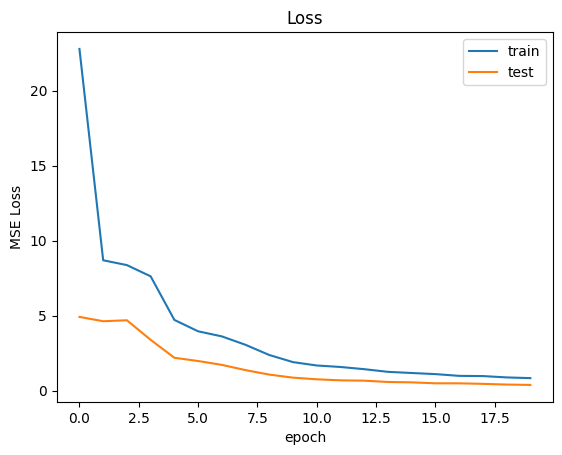

In [12]:
import matplotlib.pyplot as plt
plt.plot(x_epoch, train_loss, label='train')
plt.plot(x_epoch, test_loss, label='test')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [13]:
test(model_cnn)

Test set: Average MSE: 0.39279


0.3927904802210191

In [14]:
test_dataset = LazyLoadDataset('./lazydata/', train = False, transform = transform_with_normalization)
test_dataloader = DataLoader(test_dataset, batch_size=64 * 2, shuffle=True)

In [15]:
# Predict and save the results to a csv file

import pandas as pd

def predict(model):
    outfile = 'submission.csv'
    output_file = open(outfile, 'w')
    titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']
    
    model.eval()
    pred = []
    file_ids = []

    for i, ((img0, img1, img2, depth, field_id)) in enumerate(test_dataloader):
        data = torch.cat((img0, img1, img2, depth), dim=1).to(device)
        # data = img0.to(device)
        output = model(data)
        pred.append(output.cpu().detach().numpy())
        file_ids.extend(field_id)
    
    pred = np.concatenate(pred) / 1000.0

    df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame.from_records(pred)], axis = 1, names = titles)
    df.columns = titles
    df.to_csv(outfile, index = False)
    print("Written to csv file {}".format(outfile))

In [16]:
predict(model_cnn)

Written to csv file submission.csv
